# Генеративные состязательные сети

## Введение
Вспомним, как выглядит вариационный (или даже обычный) автоэнкодер:

![Encoder-Decoder](https://miro.medium.com/max/1400/1*UdOybs9wOe3zW8vDAfj9VA@2x.png)

Теперь представим, что у нас есть генератор случайных чисел $R$, который создает вектор $Z$ заданных размеров из заданного распределения. Пусть также у нас есть обученный декодер $D$:

$$R \rightarrow Z \in \textrm{latent space},
\quad$$

$$D = \textrm{decoder}(Z).$$

Тогда $D$ - вывод декодера, будет картинкой, похожей на те, на которых учился декодер в составе некого вариационного автоэнкодера.

**Почему важно, что автоэнкодер вариационный?**

Обычный автоэнкодер учится так, что на латентный вектор $Z$ не накладывается никаких ограничений, он может быть любым.

У такой постановки задачи есть как свои плюсы, так и свои минусы.

Минусы заключаются в том, что энкодер кодирует картинку абсолютно произвольно, поэтому декодер вынужден тоже изучать "очень большой кусок" латентного пространства и из каждого вектора этого пространства уметь генерировать картинку.

В реальности обычные автоэнкодеры, как правило, создают плохо упорядоченное пространство, а какие-либо манипуляции с латентными векторами приводят к генерации бесполезных картинок.

Вариационные автоэнкодеры кодируют картинки внутрь N-мерного шара, то есть в упорядоченный участок латентного пространства. Вариационному энкодеру достаточно научиться генерировать картинки только из этой области.

Поэтому, заставив декодер обычного автоэнкодера генерировать картинку из случайного вектора, вообще нет никаких гарантий, что мы получим адекватную картинку.

## GANs - это VAE наоборот?
**Если мы говорим исключительно об уже обученной модели**, то генератор в GAN-е действительно очень похож на декодер в VAE.


Обучение GAN-ов же реализовано по-другому:

<img src="https://www.simplilearn.com/ice9/free_resources_article_thumb/GAN.PNG">

При обучении используется две сети, они учатся вместе:
 - генератор (он создает из случайного вектора картинку, похож на декодер),
 - дискриминатор (он отличает синтезированные картинки от реальных - то есть работает как классификатор).


 Итерация обучения выглядит примерно следующим образом:
 -  Phase 1 (обучение дискриминатора):
    - 1. фиксируем веса генератора (то есть замораживаем его),  генерируем изображения (фейки),
    - 2. из датасета собирается батч реальных картинок,
    - 3. фейки и реальные картинки подаются на вход дискриминатору, его задача - предсказать, где фейки, а где реальные картинки (то есть обычный бинарный классификатор),
    - 4. считаем функцию потерь и обновляем веса только **дискриминатора**

-   Phase 2:
    - 1. фиксируя веса дискриминатора, размораживаем веса генератора, генерируем картинки (фейки),
    - 2. подаем картинки в дискриминатор, получаем предсказания дискриминатора.
    - 3. считаем функцию потерь, но теперь считаем, что фейки -
это единички (то есть мы пытаемся понять, как нам надо поменять параметры генератора, чтобы дискриминатор поверил в реалистичность наших картинок).
    - 4. обновляем веса (**только у генератора**).

На каждой итерации обучения между дискриминатором и генератором идет соревнование: кто кого обманет/перехитрит? Генератор стремится создавать картинки, максимально похожие на картинки из обучающей выборки, генератор пытается этот обман распознавать.

Код для тренировки GAN можно найти [тут](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

[Список статей с прикладным обучением GAN](https://github.com/nashory/gans-awesome-applications?tab=readme-ov-file)

Мы не будем учить его на семинаре, так как процесс может быть долгим.

# StyleGAN

StyleGAN - это одна из наиболее известных и качественных нейросетей для генерации человеческих лиц.

<img src="https://github.com/NVlabs/stylegan/raw/master/stylegan-teaser.png" width=500 height=300>

Архитектура генератора представлена ниже:

<img src="https://machinelearningmastery.com/wp-content/uploads/2019/06/Summary-of-the-StyleGAN-Generator-Model-Architecture.png" width=400 height=500>

Слева мы можем увидеть вспомогательную нейросеть Mapping network. Она выполняет преобразование над входным вектором $z$, создавая из него новые вектора. Эти вектора называются векторами стиля (или W-space векторами).

Такой подход позволяет лучше контролировать генерацию картинок: векторы стиля кодируют разные настройки результирующего изображения и вводятся в генератор на разных этапах, соответственно.

Справа мы видим, что в разные участки нейросети также вводится случайный шум (под буквами B). Этот шум, по утверждению авторов статьи, не меняет кардинально вид выходного изображения, но меняет мелкие детали (нпр. направление отдельных волос в прическе).

Благодаря использованию векторов стиля $w$ становится намного проще "редактировать" лица. Если стоит задача сделать некие изменения над лицом так, чтобы человек визуально остался тем же самым, нам, возможно, надо будет менять только определенные стилевые векторы, а не все сразу.

## Задача инверсии

Пусть есть реальная картинка $I$ с изображением человека.

**Вопрос**

Как найти латентный вектор, из которого бы при прогоне его через генератор получилась бы та самая реальная картинка?

$$ \textrm{Find }z: G(z) = I.$$


**Подход 1 (оптимизационный, медленный)**

Возьмем обученную сеть (с зафиксированными параметрами!),

- Сгенерируем случайный вектор $Z$, прогоним его через генератор, получим сгенерированное изображение $\hat I$,
- Посчитаем функцию $R = (I - \hat I)^2$
- Посчитаем $\frac{\partial R}{\partial Z}$, посчитаем $Z - \frac{\partial R}{\partial Z}$, получим новый случайный вектор.

Проведя данную операцию оптимизации ~100 раз, мы можем получить искомый вектор $Z$. То есть, нам надо будет запустить нейросеть 100 раз для поиска одного латентного вектора.

**Подход 2 (нейросетевой)**

Обучить вторую нейросеть предсказывать латентный вектор $Z$ по входной картинке, который при подаче в зафиксированный генератор выдаст картинку, максимально близкую к данной.

# pSp (pixel2style2pixel) encoder

[pSp](https://arxiv.org/pdf/2008.00951) - это архитектура для инверсии StyleGAN-а (гитхаб [тут](https://github.com/eladrich/pixel2style2pixel)).

То есть по заданной картинке pSp выдаст латентный вектор. Этот латентный вектор при подаче на вход обученному зафиксированному StyleGAN-у сгенерирует картинку, близкую к заданной.

Инверсия - это операция, с помощью которой можно делать манипуляции над картинками (в случае со StyleGAN - face editing).

Зная, какой латентный вектор кодирует ту или другую картинку, можно делать определенные манипуляции над этим вектором и добиваться изменения исходной картинки.

**Важно**

Если мы решаем задачу инверсии, то мы ее решаем для конкретного обученного генератора! Если веса генератора по каким-либо причинам изменятся, то нейросеть для инверсии также придется учить с нуля.

### Архитектура pSp

<image src="https://eladrich.github.io/pixel2style2pixel/images/architecture.png">

pSp-encoder - это сверточная нейросеть на основе ResNet, которая превращает входную картинку в латентные вектора для StyleGAN-а.

Пусть $w = pSp(x)$ - это предсказанный латентный вектор для реальной картинки $x$.

Пусть тогда $\hat x = \textrm{StyleGAN}(w)$ - сгенерированная картинка по предсказанному латентному вектору.

Задача pSp - предсказывать такой $w$, чтобы $\hat x = x$.


Обучение pSp для задачи инверсии с помощью сложной функции потерь. Рассмотрим ее слагаемые:
 - L2-loss: попиксельная разность квадратов между сгенерированной и реальной картинкой: $L2 = (x - \hat x)^2$,
 - [LPIPS-loss](https://github.com/richzhang/PerceptualSimilarity): аналог VGG-loss, для лучшей фотореалистичности,
 - ID-loss: функция потерь на основе нейросети Arcface для распознавания лиц. Эта сеть будет отвечать на вопрос, является ли сгенерированное лицо и оригинальное лицо лицом одного и того же человека,
 - регуляризующие слагаемые: нужны для более быстрого обучения. Подробно не будем их рассматривать.


Таким образом, при обучении pSp задействовано целых **4** нейросети!

# Style-based Age Manipulation (SAM)

[SAM](https://yuval-alaluf.github.io/SAM/) - это один из видов face editing на основе pSp и StyleGAN (статья [тут](https://arxiv.org/pdf/2102.02754), гитхаб [тут](https://github.com/yuval-alaluf/SAM)).

Обученная система выглядит так: на вход поступает картинка с лицом и желаемый возраст старения. На выходе: состаренный человек с исходной картинки.

Для работы этой системы требуется три нейросети:
 - pSp: для получения латентного вектора по заданному изображению,
 - age_encoder: нейросеть-манипулятор над полученным латентным вектором для получения нового латентного вектора,
 - StyleGAN: генератор лица по латентному вектору.

 <img src="https://yuval-alaluf.github.io/SAM/images/architecture.png">


 Для обучения SAM нужны следующие компоненты:

 - нужен обученный замороженный pSp,
 - нужен обученный замороженный StyleGAN,
 - нужны все слагаемые функции потерь из обучения pSp,
 - нужно возрастное слагаемое функции потерь.

Возрастное слагаемое функции потерь - это нейросеть, которая способна предсказывать возраст по входной картинке. Далее, сравнивая возраст на сгенерированной картинке с желаемым возрастом старения, мы можем посчитать градиенты этой функции и обновить age_encoder. То есть нужна **еще одна** нейросеть 😲

**Важно** учится только age_encoder (манипулятор над вектором $z$)! Все остальное заморожено.

Примерное описание цикла обучения:

**Phase 1 (старение)**:
 - загружается картинка $x$ из датасета,
 - с помощью нейросети оценивается исходный возраст человека $age_{init}$
 - случайно генерируется число из диапазона 20-90 (это желаемый возраст $age_{target}$),
 - $w = pSp(x)$ - генерируем латентный вектор исходной картинки,
 - $w' = w + age\_encoder(x, age_{target})$ - проводим манипуляции над вектором для старения,
 - $\hat x_{aging} = StyleGAN(w')$,
 - считаем все указанные функции потерь, добиваясь что возраст сгенерированной картинке равен желаемому возрасту ($L2, LPIPS, L_{ID}, L_{reg}, L_{aging}$),

**Phase 2 (восстановление)**
 - $w_{res} = pSp(\hat x)$
 - $w_{inv}' = w_{res} + age\_encoder(\hat x, age_{init})$
 - $x_{restored} = StyleGAN(w_{inv}')$,
 - считаем все указанные функции потерь, добиваясь что возраст восстановленной картинки равен возрасту исходной ($L2, LPIPS, L_{ID}, L_{reg}, L_{aging}$),

**Phase 3 (обновление параметров)**
 - складываем loss из первой и второй стадии, обновляем параметры age_encoder - a.

In [ ]:
! wget https://github.com/yuval-alaluf/SAM/archive/refs/heads/master.zip
! unzip master.zip
! mv SAM-master SAM

--2024-08-29 07:51:40--  https://github.com/yuval-alaluf/SAM/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/yuval-alaluf/SAM/zip/refs/heads/master [following]
--2024-08-29 07:51:41--  https://codeload.github.com/yuval-alaluf/SAM/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.116.10
Connecting to codeload.github.com (codeload.github.com)|140.82.116.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [      <=>           ]   3.95M  2.63MB/s    in 1.5s    

2024-08-29 07:51:43 (2.63 MB/s) - ‘master.zip’ saved [4144114]

Archive:  master.zip
c1895aef275e702fba7560284dc16df60d65210e
   creating: SAM-master/
  inflating: SAM-master/.gitignore   
  inflating: SAM-mas

In [ ]:
!pip install gdown
!mkdir pretrained_models
!wget "https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat"
!gdown "https://drive.google.com/u/0/uc?id=1XyumF6_fdAxFmxpFcmPf-q84LU_22EMC&export=download" -O pretrained_models/sam_ffhq_aging.pt
!gdown "https://drive.google.com/u/0/uc?id=1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0&export=download" -O pretrained_models/psp_ffhq_encode.pt
!gdown "https://drive.google.com/u/0/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&export=download" -O pretrained_models/stylegan2-ffhq-config-f.pt

# these models are required only for training
#!gdown "https://drive.google.com/u/0/uc?id=1KW7bjndL3QG3sxBbZxreGHigcCCpsDgn&export=download" -O pretrained_models/model_ir_se50.pth
#!gdown "https://drive.google.com/u/0/uc?id=1atzjZm_dJrCmFWCqWlyspSpr3nI6Evsh&export=download" -O pretrained_models/dex_age_classifier.pth

--2024-08-29 07:53:03--  https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat [following]
--2024-08-29 07:53:04--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>] 

In [ ]:
from argparse import Namespace
import sys
sys.path.append('SAM') # теперь можно из папки SAM импортировать любые объекты

In [ ]:
!pip install ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 19.4 MB/s eta 0:00:00


In [ ]:
import dlib
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from datasets.augmentations import AgeTransformer
from models.psp import pSp
from scripts.align_all_parallel import align_face

/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [ ]:
# маленькая модель для выравнивания лица на основе 68 меш-точек лица
def run_alignment(image_path):
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image

In [ ]:
inference_transforms = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)

In [ ]:
parameters = {
    'exp_dir': '',
    'dataset_type': 'ffhq_aging',
    'input_nc': 4,
    'label_nc': 0,
    'output_size': 1024,
    'batch_size': 6,
    'test_batch_size': 6,
    'workers': 6,
    'test_workers': 6,
    'learning_rate': 0.0001,
    'optim_name': 'ranger',
    'train_decoder': False,
    'start_from_latent_avg': False,
    'start_from_encoded_w_plus': True,
    'lpips_lambda': 0.1,
    'id_lambda': 0.1,
    'l2_lambda': 0.25,
    'w_norm_lambda': 0.005,
    'aging_lambda': 5.0,
    'cycle_lambda': 1.0,
    'lpips_lambda_crop': 0.6,
    'l2_lambda_crop': 1.0,
    'lpips_lambda_aging': 0.1,
    'lpips_lambda_aging': 0.1,
    'l2_lambda_aging': 0.25,
    'stylegan_weights': '',
    'checkpoint_path': 'pretrained_models/sam_ffhq_aging.pt',
    'max_steps': 500000,
    'image_interval': 100,
    'board_interval': 50,
    'val_interval': 2500,
    'save_interval': 2500,
    'use_weighted_id_loss': True,
    'pretrained_psp_path': '',
    'device': 'cuda',
    'target_age': 'uniform_random',
    'pretrained_psp_model': 'pretrained_models/psp_ffhq_encode.pt',
}

sam_parameters = Namespace(**parameters)

In [ ]:
aging_net = pSp(sam_parameters)
_ = aging_net.eval()
_= aging_net.cuda()

Loading SAM from checkpoint: pretrained_models/sam_ffhq_aging.pt


/content/SAM/models/psp.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(self.opts.checkpoint_path, map_location='cpu')


Aligned image has shape: (256, 256)


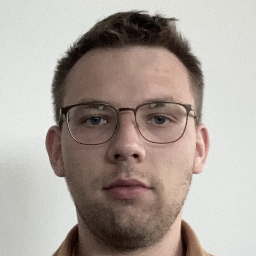

In [ ]:
aligned_image = run_alignment('egor.jpg')
aligned_image

In [ ]:
target_age = AgeTransformer(target_age=10)
input_image = inference_transforms(aligned_image)

In [ ]:
input_image.shape

torch.Size([3, 256, 256])

In [ ]:
print(f"Running on target age: {target_age.target_age}")
with torch.no_grad():
    input_image_age = [target_age(input_image.cpu()).to("cuda")]
    input_image_age = torch.stack(input_image_age)
    result_tensor = aging_net(input_image_age, randomize_noise=False, resize=False)
print("Done!")
image = (result_tensor[0].cpu().transpose(0,2).transpose(0,1).numpy() + 1)/2
image = (image* 255).clip(0, 255).astype('uint8')

Running on target age: 10
Done!


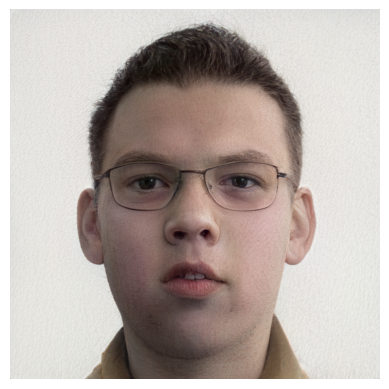

In [ ]:
plt.imshow(image)
plt.axis('off')
plt.show()